In [1]:
# import pandas and matplotlib
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# import SQLalchemy create_engine, automap_base, session
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import distinct

In [3]:
import datetime as dt

# Hawaii trip period
* Start date - 2017/07/08
* End data - 2017/07/15

In [4]:
# create engine for the hawaii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# use inpector to explore database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# use inpector to print column names and types for measurement
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# refelct database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement

In [8]:
# start session to query the database
session = Session(engine)

In [9]:
# create variable to hold the query values for date and preciptation,
# last 12 months of data from the end of my trip 2017/07/15

# create variable to hold the date 12 months before the end of the trip
query_date = dt.date(2017, 7,15) - dt.timedelta(days=365)
end_date = dt.datetime(2017, 7, 15)
# using the query_date created, filter the query session to get all the precipitation 
# for the 12 months
query_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).all()

In [10]:
# load the results from the variable created into Pandas dataframe 
measurement_df = pd.DataFrame(query_precipitation)
# set index on date
measurement_df.set_index('date', inplace=True)
# sort values by date
measurement_df.sort_values(by='date')
# rename prcp to Precipitation for readability
measurement = measurement_df.rename(columns={"prcp":"Precipitation"})
# clean data by dropping any na value
measurement_results = measurement.dropna()
# now that the dataframe is sorted by date, reset index to use dates as a list to plot
measurement_reset_index = measurement_results.reset_index()

#unpack results into lists to plot
dates = [date for date in measurement_reset_index['date']]
precipitations = [precipitation for precipitation in measurement_reset_index['Precipitation']]

## Precipitation Analysis

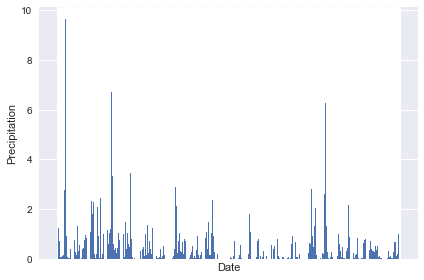

In [11]:
fig, ax =  plt.subplots()
x_axis = np.arange(len(dates))
ax.bar(dates, precipitations)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
plt.grid(True)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.show()

In [12]:
measurement_reset_index.describe()

,Precipitation
count,2054.000000
mean,0.204245
std,0.567003
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [13]:
# use inpector to print column names and types for station
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Station Analysis

In [14]:
# counts the number os stations available in this dataset
query_stations = session.query(func.distinct(Measurement.station)).count()
print(query_stations)

9


Most active stations in descending order

In [15]:
# finds the most active stations in descending order
active_stations = session.query((Measurement.station),\
    func.count(Measurement.station).label("Station_Activity")).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Most active station's highest, lowest and average temperatures

In [16]:
# most active station (USC00519281)lowest temperature, highest temperature and average temp
most_active_station = session.query(func.min(Measurement.tobs).label('lowest_temp'),\
                      func.max(Measurement.tobs).label('highest_temp'),\
                      func.avg(Measurement.tobs).label('average_temp')).\
                      filter(Measurement.station == "USC00519281").all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

12 months tobs filtered by station with highest number of observations 

In [17]:
# find station with the highest number of temperarute observations
# filtering by the period 12 months before the end of the trip

tobs_last_12months = session.query(Measurement.station,\
    func.count(Measurement.tobs).label("Highest_number_observations")).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
tobs_last_12months

[('USC00513117', 365),
 ('USC00519281', 365),
 ('USC00519397', 363),
 ('USC00516128', 347),
 ('USC00519523', 340),
 ('USC00514830', 297),
 ('USC00517948', 195)]

* top station tobs

In [18]:
# get all the data from the top station only
top_station_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.date < end_date).\
    filter(Measurement.station == 'USC00513117').all()

In [19]:
# put the date into a Pandas dataframe to plot the histogram
top_station_tobs_df = pd.DataFrame(top_station_tobs)
top_station_tobs_df.head()

,tobs
0,75.0
1,76.0
2,76.0
3,75.0
4,78.0


* Histogram

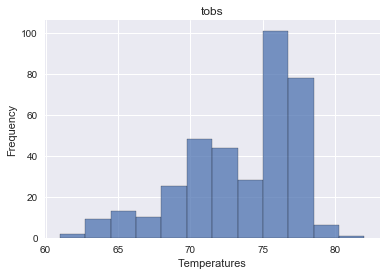

In [20]:
hist = top_station_tobs_df.hist(bins=12,edgecolor='black',alpha=0.75)

plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.show()

*Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
* and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))


In [78]:
# Highest temperature, lowest temperature and average temperature for the trip duration
def calc_temps(start_date, end_date):
    start_date = session.query(func.strftime("%Y-%m-%d", Measurement.date))
    end_date = session.query(func.strftime("%Y-%m-%d", Measurement.date))
                                             
    return session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
           func.avg(Measurement.tobs)).filter(Measurement.date >= start_date).\
           filter(Measurement.date <= end_date).all()


print(calc_temps('17-7-8', '2017-07-15'))    


InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type. [SQL: 'SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 \nFROM measurement \nWHERE measurement.date >= ? AND measurement.date <= ?'] [parameters: (('2010-01-01',), ('2010-01-01',))] (Background on this error at: http://sqlalche.me/e/rvf5)

In [73]:
# previous year (2016) Highest temperature, lowest temperature and average temperature 
print(calc_temps('2016-7-08', '2016-07-15'))

[(65.0, 75.0, 69.71428571428571)]
